In [1]:
# Install required libraries
!pip install numpy pandas tensorflow scikit-learn

In [3]:
import os
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras import layers, Model
from tensorflow.keras.applications import DenseNet121
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, confusion_matrix, precision_recall_curve
import matplotlib.pyplot as plt

2025-04-30 04:12:48.707512: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1745986368.892535      31 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1745986368.943723      31 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [4]:
# Set random seeds for reproducibility
np.random.seed(42)
tf.random.set_seed(42)

In [5]:
# --- Step 1: Load Dataset ---
DATA_DIR = '/kaggle/input/koadataset'
csv_path = os.path.join(DATA_DIR, 'ground_truth.csv')
df = pd.read_csv(csv_path)

# Rename 'kl_grade' to 'label'
df = df.rename(columns={'kl_grade': 'label'})

# Create image paths
df['image_path'] = df.apply(
    lambda row: os.path.join(DATA_DIR, str(row['label']), row['filename']), axis=1
)
df = df[df['image_path'].apply(os.path.exists)]
print(f"Rows after filtering: {len(df)}")
print("Class distribution:")
print(df['label'].value_counts())

# Split into train and validation sets
train_df, val_df = train_test_split(df, test_size=0.2, random_state=42, stratify=df['label'])
IMG_SIZE = (256, 256)
BATCH_SIZE = 8

Rows after filtering: 7828
Class distribution:
label
0    3085
2    2062
1    1416
3    1265
Name: count, dtype: int64


In [6]:
# --- Step 2: Data Pipeline ---
def preprocess_image(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=1)  # Grayscale
    img = tf.image.resize(img, IMG_SIZE)
    img = tf.image.random_flip_left_right(img)  # Minimal augmentation
    img = img / 255.0  # Normalize to [0, 1]
    # Duplicate channels to match DenseNet's 3-channel input
    img = tf.repeat(img, repeats=3, axis=-1)
    return img, label

In [7]:
def preprocess_image_val(image_path, label):
    img = tf.io.read_file(image_path)
    img = tf.image.decode_jpeg(img, channels=1)
    img = tf.image.resize(img, IMG_SIZE)
    img = img / 255.0
    img = tf.repeat(img, repeats=3, axis=-1)
    return img, label

train_dataset = tf.data.Dataset.from_tensor_slices((
    train_df['image_path'].values,
    train_df['label'].values
)).map(preprocess_image, num_parallel_calls=tf.data.AUTOTUNE).shuffle(200).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

val_dataset = tf.data.Dataset.from_tensor_slices((
    val_df['image_path'].values,
    val_df['label'].values
)).map(preprocess_image_val, num_parallel_calls=tf.data.AUTOTUNE).batch(BATCH_SIZE).prefetch(tf.data.AUTOTUNE)

I0000 00:00:1745986404.728549      31 gpu_device.cc:2022] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 15513 MB memory:  -> device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0


In [8]:
# --- Step 3: Define DenseNet121 Model ---
base_model = DenseNet121(weights='imagenet', include_top=False, input_shape=(256, 256, 3))
base_model.trainable = True  # Fine-tune all layers

inputs = layers.Input(shape=(256, 256, 3))
x = base_model(inputs, training=True)
x = layers.GlobalAveragePooling2D()(x)
x = layers.Dropout(0.5)(x)  # Prevent overfitting
outputs = layers.Dense(4, activation='softmax')(x)
model = Model(inputs, outputs)

model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=1e-4),
              loss='sparse_categorical_crossentropy',
              metrics=['accuracy'])
model.summary()

29084464/29084464 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ input_layer_1 (InputLayer)           │ (None, 256, 256, 3)         │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ densenet121 (Functional)             │ (None, 8, 8, 1024)          │       7,037,504 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ global_average_pooling2d             │ (None, 1024)                │               0 │
│ (GlobalAveragePooling2D)             │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 1024)                │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 4)                   │           4,100 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 7,041,604 (26.86 MB)

 Trainable params: 6,957,956 (26.54 MB)

 Non-trainable params: 83,648 (326.75 KB)

In [9]:
# --- Step 4: Class Weights ---
class_counts = train_df['label'].value_counts().sort_index()
total_samples = len(train_df)
class_weights = {i: total_samples / (4 * count) for i, count in enumerate(class_counts)}
print("Class weights:", class_weights)

Class weights: {0: 0.6343192868719612, 1: 1.381729920564872, 2: 0.9493632504548211, 3: 1.5469367588932805}


In [10]:
# --- Step 5: Train the Model ---
history = model.fit(
    train_dataset,
    epochs=50,
    validation_data=val_dataset,
    class_weight=class_weights,
    callbacks=[]  # Removed EarlyStopping callback
)

Epoch 1/50


I0000 00:00:1745986513.322449     100 service.cc:148] XLA service 0x79029c0030c0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1745986513.323329     100 service.cc:156]   StreamExecutor device (0): Tesla P100-PCIE-16GB, Compute Capability 6.0
I0000 00:00:1745986522.057188     100 cuda_dnn.cc:529] Loaded cuDNN version 90300


  1/783 ━━━━━━━━━━━━━━━━━━━━ 37:48:38 174s/step - accuracy: 0.1250 - loss: 1.8770

I0000 00:00:1745986597.369133     100 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


783/783 ━━━━━━━━━━━━━━━━━━━━ 340s 212ms/step - accuracy: 0.3718 - loss: 1.4528 - val_accuracy: 0.6194 - val_loss: 0.9249
Epoch 2/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 65s 83ms/step - accuracy: 0.5414 - loss: 1.0301 - val_accuracy: 0.6628 - val_loss: 0.8130
Epoch 3/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 65s 83ms/step - accuracy: 0.5910 - loss: 0.9143 - val_accuracy: 0.6207 - val_loss: 0.8664
Epoch 4/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 66s 84ms/step - accuracy: 0.6265 - loss: 0.8495 - val_accuracy: 0.6750 - val_loss: 0.8080
Epoch 5/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 66s 83ms/step - accuracy: 0.6743 - loss: 0.7273 - val_accuracy: 0.6628 - val_loss: 0.8158
Epoch 6/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 66s 83ms/step - accuracy: 0.6766 - loss: 0.7181 - val_accuracy: 0.6679 - val_loss: 0.8190
Epoch 7/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 66s 83ms/step - accuracy: 0.7205 - loss: 0.6164 - val_accuracy: 0.6392 - val_loss: 0.9399
Epoch 8/50
783/783 ━━━━━━━━━━━━━━━━━━━━ 65s 83ms/step - accuracy: 0.7592 - loss: 0.5559 - val_accur

In [11]:
# --- Step 6: Evaluation ---
# Get true labels and predictions
y_true = []
y_pred = []
y_scores = []

for images, labels in val_dataset:
    preds = model.predict(images, verbose=0)
    y_true.extend(labels.numpy())
    y_pred.extend(np.argmax(preds, axis=1))
    y_scores.extend(preds)

y_true = np.array(y_true)
y_pred = np.array(y_pred)
y_scores = np.array(y_scores)

# Accuracy
test_accuracy = accuracy_score(y_true, y_pred)
print(f'Test Accuracy: {test_accuracy:.4f}')

Test Accuracy: 0.8500


In [12]:
# Precision, Recall, F1-Score (weighted)
precision, recall, f1, _ = precision_recall_fscore_support(y_true, y_pred, average='weighted')
print(f'Weighted Precision: {precision:.4f}')
print(f'Weighted Recall: {recall:.4f}')
print(f'Weighted F1-Score: {f1:.4f}')

Weighted Precision: 0.6929
Weighted Recall: 0.6622
Weighted F1-Score: 0.6700


Confusion Matrix:
 [[412 142  62   1]
 [ 58 123  97   5]
 [ 24  53 314  22]
 [  1   3  61 188]]


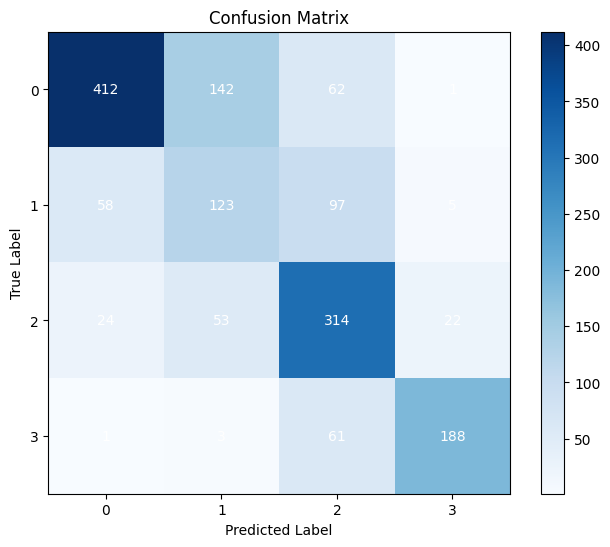

In [13]:
# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)
print("Confusion Matrix:\n", cm)
plt.figure(figsize=(8, 6))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.xticks(np.arange(4), ['0', '1', '2', '3'])
plt.yticks(np.arange(4), ['0', '1', '2', '3'])
for i in range(4):
    for j in range(4):
        plt.text(j, i, cm[i, j], ha='center', va='center', color='white')
plt.show()

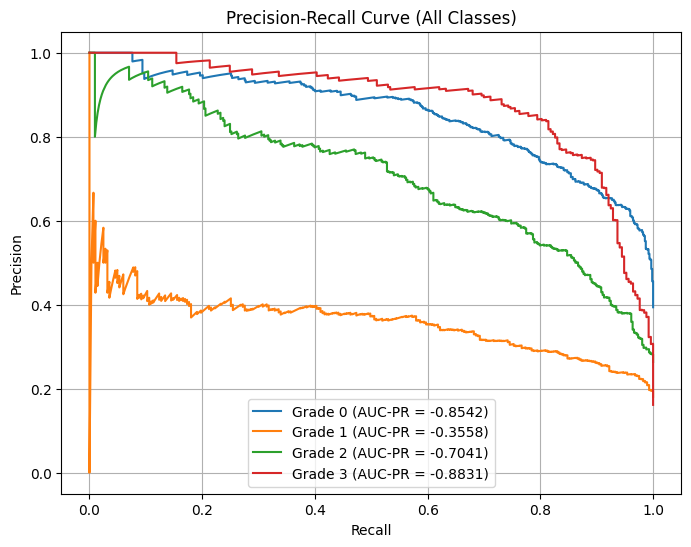

In [14]:
# Precision-Recall Curve
plt.figure(figsize=(8, 6))
for i in range(4):
    precision_curve, recall_curve, _ = precision_recall_curve(y_true == i, y_scores[:, i])
    auc_pr = np.trapz(precision_curve, recall_curve)
    plt.plot(recall_curve, precision_curve, label=f'Grade {i} (AUC-PR = {auc_pr:.4f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (All Classes)')
plt.legend()
plt.grid()
plt.show()

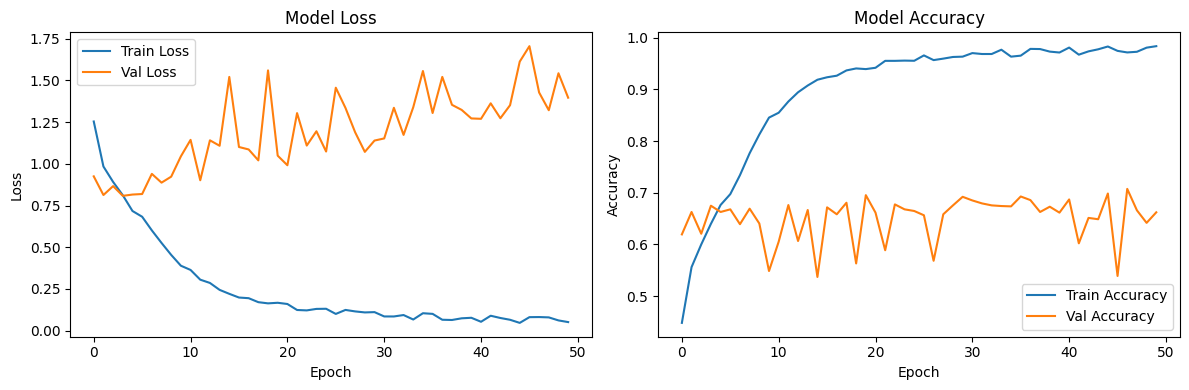

In [15]:
# Training/Validation Curves
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Val Loss')
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Val Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.tight_layout()
plt.show()